In [1]:
from pyofss import Domain, System, Gaussian, Fibre, OpenclFibre
from pyofss import temporal_power, spectral_power, lambda_to_nu, nu_to_lambda, multi_plot, labels
import numpy as np
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import pylab as plt
plt.switch_backend('agg')

import time
%matplotlib inline


In [2]:
lamb0 = 1028
peak_power = 0.1  
peak_width = 2    
peak_C = 0.
total_steps = 8000
betta_2 = 20  
gamma_active = 5  
La_1 = 2*1e-3

Pp_0 = 10               # Ws
N = 4.8
Rr = 80*1e-6            # THz
Tr = 1/Rr    

domain = Domain(samples_per_bit=2**14, bit_width=200.0,
                total_bits=1, centre_nu=lambda_to_nu(lamb0))
gaussian = Gaussian(name="initial_pulse", peak_power=peak_power,
                    width=peak_width, C=peak_C, using_fwhm=True)

In [3]:
fib = Fibre(length=La_1, total_steps=total_steps, traces=total_steps, 
            beta=[0.0, 0.0, betta_2], gamma=gamma_active, self_steepening=False, use_all=True,
            use_Yb_model=True, N=N, Pp_0=Pp_0, Rr=Rr)

sys = System(domain)
sys.add(gaussian)
sys.add(fib)

start = time.time()
sys.run()
stop = time.time()
NO_CL_OUT = sys.field

print("Run time without cl is {}".format(stop-start))

use two level Yb gain model
Using general expression for nonlinearity
Caching linear factor


c:\Users\User1\Programs\examples\pyofss\modules\amplifier.py:276: RuntimeWarning: invalid value encountered in true_divide
  self._ratio_s = self.sigma12_s / (self.sigma12_s + self.sigma21_s)
c:\Users\User1\Programs\examples\pyofss\modules\amplifier.py:212: RuntimeWarning: divide by zero encountered in true_divide
  self._Psat_s = (self.h_p * self.domain.nu * 1e12) / (self.T * (self.sigma12_s + self.sigma21_s) * self.rho_s)


Run time without cl is 231.23578763008118


In [4]:
sys1 = System(domain)
sys1.add(gaussian)
sys1.add(OpenclFibre(length=La_1, total_steps=total_steps,
            beta=[0.0, 0.0, betta_2], gamma=gamma_active, self_steepening=False, use_all=True,
            use_Yb_model=True, N=N, Pp_0=Pp_0, Rr=Rr,
            dorf='double'))
start = time.time()
sys1.run()
stop = time.time()
CL_OUT = sys1.field

print("Run time with cl is {}".format(stop-start))

use two level Yb gain model
Using general expression for nonlinearity
Caching linear factor
Run time with cl is 85.92889928817749


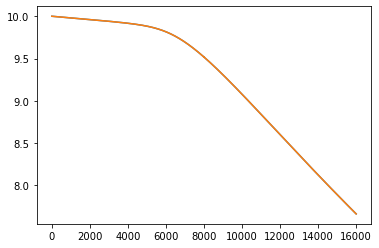

In [5]:
plt.plot(sys1.modules[1].amplifier.Pp_list)
plt.plot(sys.modules[1].amplifier.Pp_list)

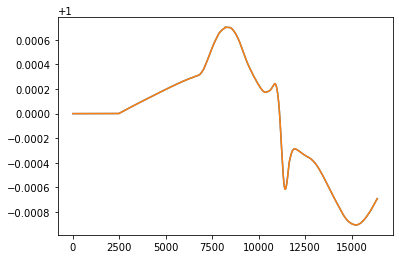

In [6]:
plt.plot(sys1.modules[1].amplifier.gs_list[4000])
plt.plot(sys.modules[1].amplifier.gs_list[4000])

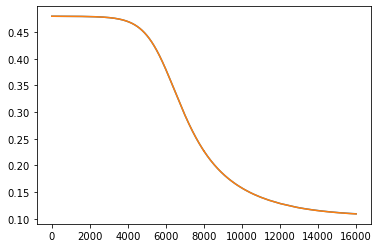

In [7]:
plt.plot(sys1.modules[1].amplifier.inversion_factor_list)
plt.plot(sys.modules[1].amplifier.inversion_factor_list)

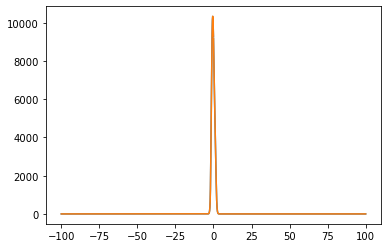

In [8]:
%matplotlib inline
plt.plot(domain.t, temporal_power(sys1.field))
plt.plot(domain.t, temporal_power(sys.field))
plt.show()

In [13]:
sys.df_results

,max_value,energy,duration,spec_width,peaks
z [mm],,,,,
0.125,0.100143,0.000213,2.000006,0.220641,[8192]
0.250,0.100287,0.000214,2.000008,0.220641,[8192]
0.375,0.100431,0.000214,2.000010,0.220640,[8192]
0.500,0.100575,0.000214,2.000011,0.220640,[8192]
0.625,0.100719,0.000214,2.000013,0.220639,[8192]
...,...,...,...,...,...
999.500,1899.201539,4.092502,2.026920,0.244639,[8192]
999.625,1900.224810,4.094729,2.026934,0.244695,[8192]
999.750,1901.248263,4.096956,2.026948,0.244751,[8192]


In [14]:
sys1.df_results

,max_value,energy,duration,spec_width,peaks
z [mm],,,,,
0.000,0.100143,0.000213,NaN,NaN,[8192]
0.125,0.100287,0.000214,NaN,NaN,[8192]
0.250,0.100431,0.000214,NaN,NaN,[8192]
0.375,0.100575,0.000214,NaN,NaN,[8192]
0.500,0.100719,0.000214,NaN,NaN,[8192]
...,...,...,...,...,...
999.375,80609.075676,174.427917,NaN,NaN,[8201]
999.500,80858.136181,174.962465,NaN,NaN,[8201]
999.625,81107.969986,175.498608,NaN,NaN,[8201]


No handles with labels found to put in legend.



Generating multi_plot...


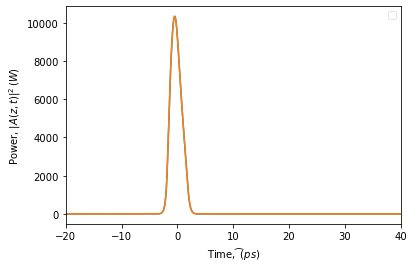

No handles with labels found to put in legend.



Generating multi_plot...


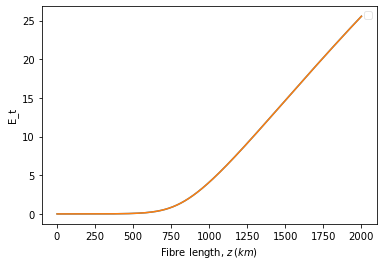

Mean relative error: 4.484606e-05
Max relative error: 5.108426e-03


<Figure size 432x288 with 0 Axes>

In [9]:
multi_plot(sys1.domain.t, [temporal_power(sys.field), temporal_power(sys1.field)], ["cpu", "gpu"], labels["t"], labels["P_t"],
            x_range=(-20.0, 40.0), use_fill=False)
plt.savefig('raman_cl_compare')
df_results = sys.df_results  
df_results1 = sys1.df_results
energy_arr = df_results['energy'].values
energy_arr1 = df_results1['energy'].values
multi_plot(df_results.index.get_level_values("z [mm]").values, [energy_arr, energy_arr1], ["cpu", "gpu"], labels["z"], "E_t", use_fill=False)
plt.savefig('raman_cl_compare_energy')

NO_CL_POWER = temporal_power(NO_CL_OUT)
CL_POWER = temporal_power(CL_OUT)
DELTA_POWER = NO_CL_POWER - CL_POWER

MEAN_RELATIVE_ERROR = np.mean(np.abs(DELTA_POWER))
MEAN_RELATIVE_ERROR /= np.max(temporal_power(NO_CL_OUT))

MAX_RELATIVE_ERROR = np.max(np.abs(DELTA_POWER))
MAX_RELATIVE_ERROR /= np.max(temporal_power(NO_CL_OUT))

print("Mean relative error: %e" % MEAN_RELATIVE_ERROR)
print("Max relative error: %e" % MAX_RELATIVE_ERROR)

In [10]:
fib = Fibre(length=La_1, total_steps=total_steps, traces=total_steps, 
            beta=[0.0, 0.0, betta_2], gamma=gamma_active, self_steepening=False, use_all=True)

sys = System(domain)
sys.add(gaussian)
sys.add(fib)

start = time.time()
sys.run()
stop = time.time()
NO_CL_OUT = sys.field

print("Run time without cl is {}".format(stop-start))

Using general expression for nonlinearity
Caching linear factor


In [ ]:
sys1 = System(domain)
sys1.add(gaussian)
sys1.add(OpenclFibre(length=La_1, total_steps=total_steps,
            beta=[0.0, 0.0, betta_2], gamma=gamma_active, self_steepening=False, use_all=True,
            dorf='double'))
start = time.time()
sys1.run()
stop = time.time()
CL_OUT = sys1.field

print("Run time with cl is {}".format(stop-start))

Using general expression for nonlinearity
Caching linear factor
Run time with cl is 8.45951223373413


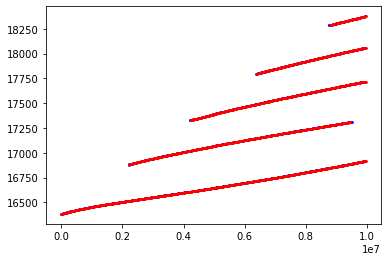

In [59]:
%matplotlib inline

for i in range(len(sys1.df_results['peaks'].values)):
    peaks_arr = np.array(sys1.df_results['peaks'].values[i])
    z_arr = np.full(peaks_arr.shape, sys1.df_results.index.get_level_values("z [mm]").values[i])
    plt.scatter(z_arr, peaks_arr, s=3, c="b")


for i in range(len(sys.df_results['peaks'].values)):
    peaks_arr = np.array(sys.df_results['peaks'].values[i])
    z_arr = np.full(peaks_arr.shape, sys.df_results.index.get_level_values("z [mm]").values[i])
    plt.scatter(z_arr, peaks_arr, s=3, c="r")
plt.show()